# Heart Disease Classification (Group 5)


## Introduction

Heart disease is a common health condition that affects many people around the world, with coronary disease being a significant contributor to its prevalence. Coronary artery disease refers to the buildup of plaque in the wall of the arteries that supply blood to the heart, otherwise known as atherosclerosis. Plaque buildup will cause the inside of the arteries to narrow over time, leading to reduced blood flow to the heart muscle. Various diagnostic measures, such as cholesterol levels, blood pressure, and electrocardiogram (ECG) readings, play crucial roles in assessing the presence and severity of this condition. Given the significant impact of coronary disease on public health, predictive analytics can help us gain a better understanding of the relationship between risk factors and disease development, ultimately guiding efforts to prevent and manage heart disease effectively.

Through our predictive analysis, we hope to address the following question


**Question:** How can we use diagnostic measurements such as age, sex, chest pain type, resting blood pressure, serum cholesterol, fasting blood sugar level, resting electrocardiographic results, … etc, to classify whether a patient has heart disease? (Presence  = 1,2,3,4; Absence =s).

**Our dataset:** The dataset we have selected is a subset ofed heart disease diagnosis database that contains information about 303 unique patients undergoing angiography at the Cleveland Clinic in Cleveland, Ohio. Each entry contains 14 attributes for each patient as listed in the following: 

- Age (age)
- Sex (sex)
- Chest pain type (cp)
    - Value 1: Typical angina
    - Value 2: Atypical angina
    - Value 3: Non-anginal pain
    - Value 4: Asymptomatic   
- Resting blood pressure (trestbps)  
    - In mm Hg on admission to the hospital
- Serum cholesterol (chol)
    - In mg/dl      
- Fasting blood sugar > 120 mg/dl  (fbs)       
    - Value 0: false
    - Value 1: true
- Resting electrocardiographic results (restecg)   
    - Value 0: Normal
    - Value 1: Having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: Showing probable or definite left ventricular hypertrophy by Estes' criteria
- Maximum heart rate achieved (thalach)   
- Exercise induced angina (exang) 
    - Value 0: No
    - Value 1: Yes 
- ST depression induced by exercise relative to rest (oldpeak)   
- The slope of the peak exercise ST segment  (slope) 
    - Value 1: Upsloping
    - Value 2: Flat
    - Value 3: Downsloping  
- Number of major vessels (0-3) colored by flourosopy (ca)     
- Exercise Thallium heart scan (thal)
    - Value 3: Normal
    - Value 6: Fixed defect
    - Value 7: Reversable defect     
- Diagnosis of heart disease: Angiographic disease status (num) 
    - Value 0: < 50% diameter narrowing
    - Value 1: > 50% diameter narrowing



## Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Reading the data

In [2]:
heart_disease_data <- read.csv("data/processed_cleveland.csv")
colnames(heart_disease_data) <- c("Age", "Sex", "Chest_Pain_Type", "Resting_Blood_Pressure", "Serum_Cholestoral", "Fasting_Blood_Sugar", "Resting_ECG", "Max_Heart_Rate", "Exercise_Induced_Angina", "ST_depression", "Slope", "Vessels_Number", "Exercise_Thallium_Heart_Scan", "Status")
heart_disease_data <- heart_disease_data |>
                mutate(Status = as_factor(Status)) |>
                mutate(Status = fct_recode(Status, "Absense" = "0", "Presence" = "1", "Presence" = "2", "Presence" = "3", "Presence" = "4"))

### Selecting potential predictors among the variables

In [3]:
# This is to separate the data/columns we will use in our model to classify whether the patient has heart disease or not.
heart_data <- select(heart_disease_data, Age, Resting_Blood_Pressure, Serum_Cholestoral, Max_Heart_Rate, ST_depression, Status)
heart_data 

Age,Resting_Blood_Pressure,Serum_Cholestoral,Max_Heart_Rate,ST_depression,Vessels_Number,Status
<int>,<int>,<int>,<int>,<dbl>,<chr>,<fct>
63,145,233,150,2.3,0,Absense
67,160,286,108,1.5,3,Presence
67,120,229,129,2.6,2,Presence
⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,130,131,115,1.2,1,Presence
57,130,236,174,0.0,1,Presence
38,138,175,173,0.0,?,Absense


### Summarizing the data

We are going to use only training data from this point on for our data exploration.

In [4]:
#splitting dataframe into training, testing datasets
heart_split <- initial_split(heart_data, prop = 0.75, strata = Status)

heart_train <- training(heart_split)
heart_test <- testing(heart_split)

First, we have derived some summary statistics for each of the predictor values in our dataset. The following table displays the mean of each predictor variable and the count of each observation, grouped by the patients with and without presence of heart disease in the dataset.

In [7]:
#summarizing to get mean of each predictor
heart_summary <- heart_train |>
                    group_by(Status) |>
                    summarize(mean_Age = mean(Age), mean_Resting_Blood_Pressure = mean(Resting_Blood_Pressure),
                              mean_Serum_Cholestoral = mean(Serum_Cholestoral), 
                              mean_Max_Heart_Rate = mean(Max_Heart_Rate), mean_ST_depression = mean(ST_depression),
                              n_count = n(), missing_data_count = sum(is.na(heart_train)))

heart_summary

Status,mean_Age,mean_Resting_Blood_Pressure,mean_Serum_Cholestoral,mean_Max_Heart_Rate,mean_ST_depression,n_count,missing_data_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
Absense,53.07317,129.4715,245.8293,158.7724,0.5504065,123,0
Presence,56.75962,134.5000,255.1154,138.2500,1.6596154,104,0


### Visualizing the data

Then, we can use the visualizations below compare the distribution of the predictors we will be using for our analysis.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


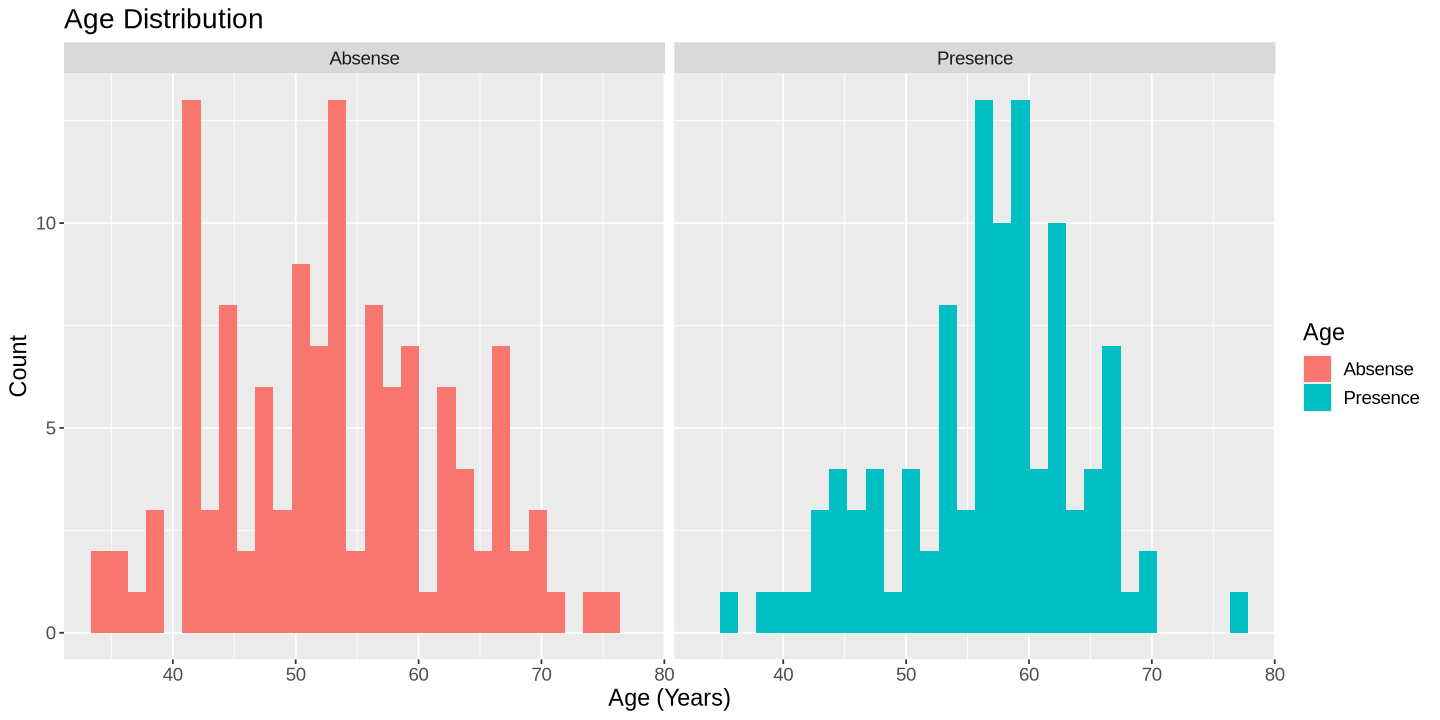

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


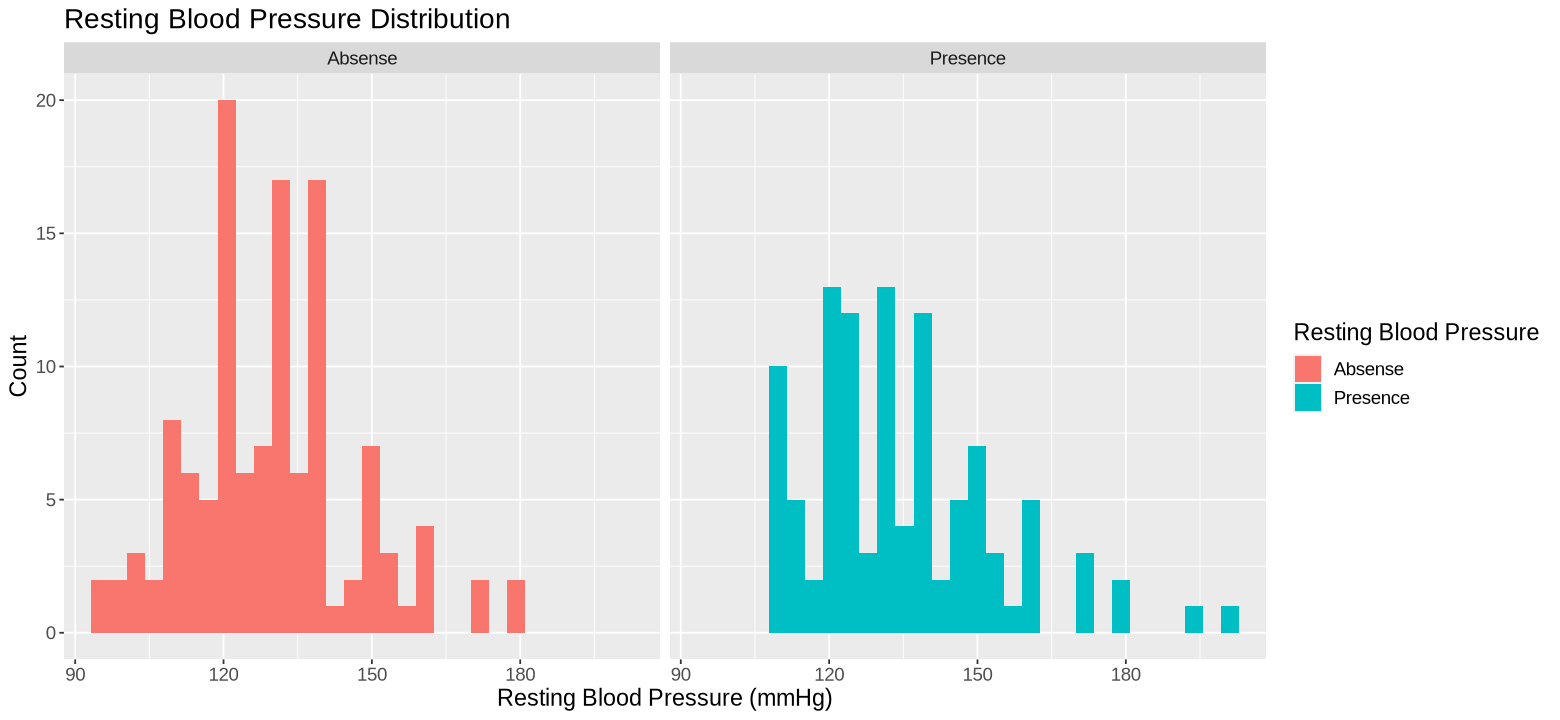

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


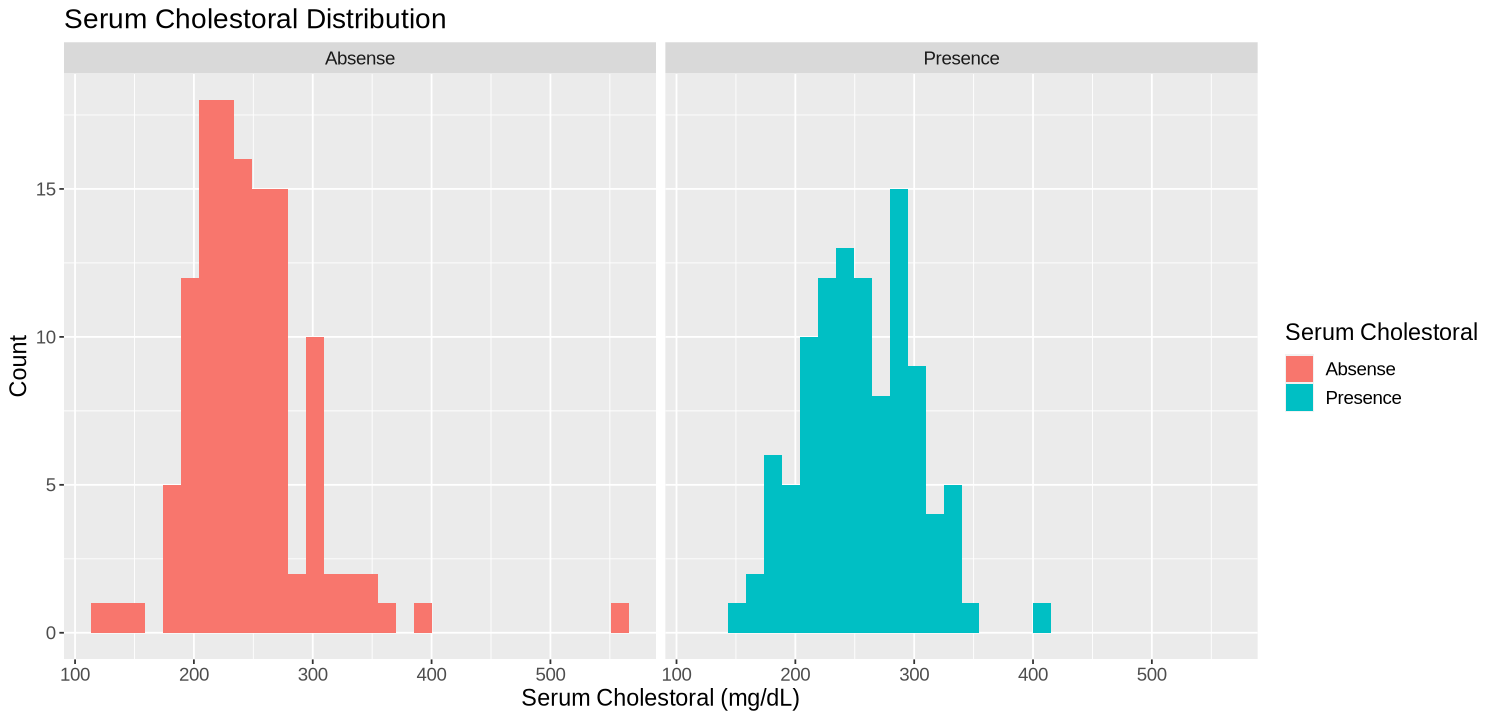

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


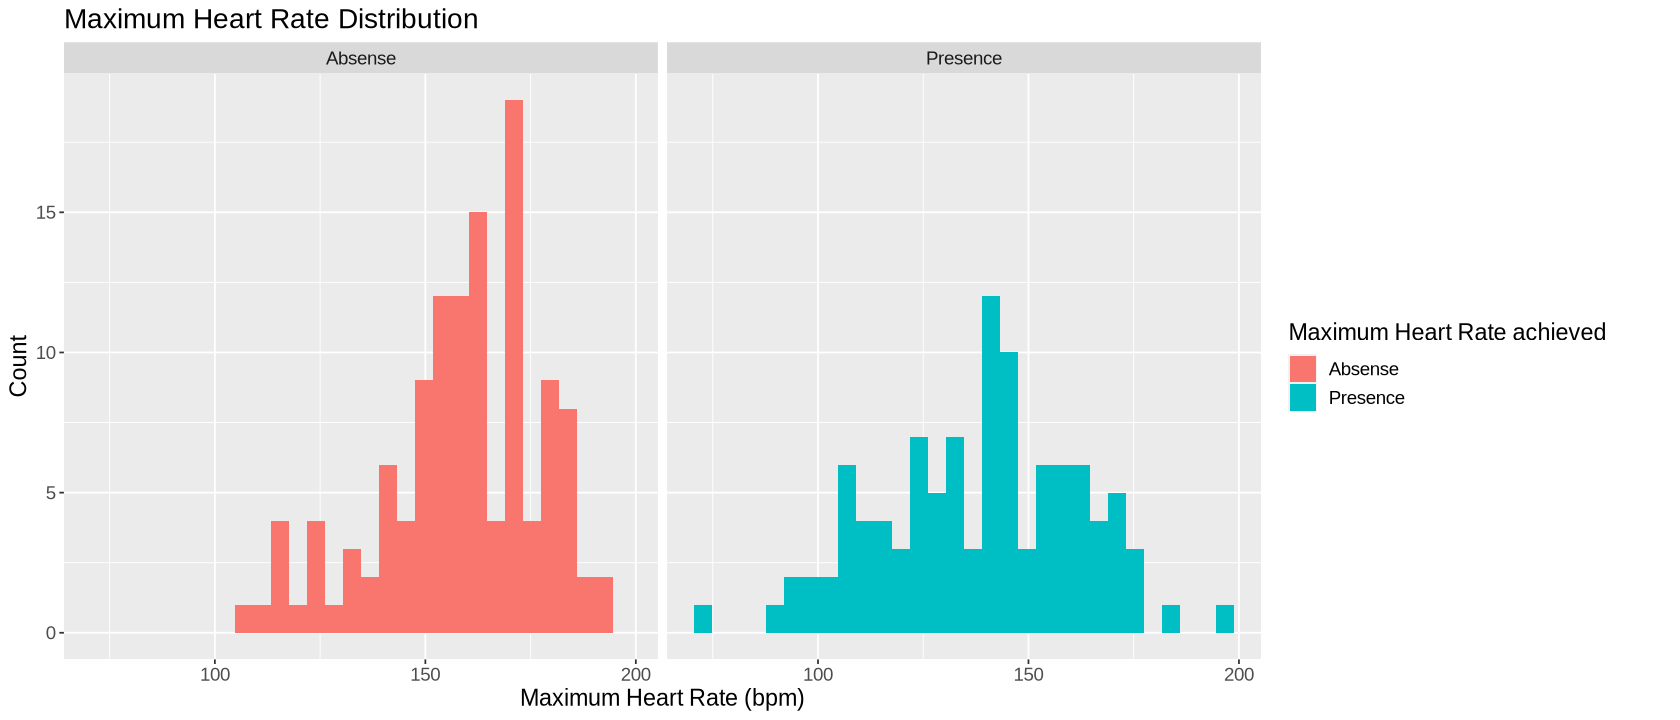

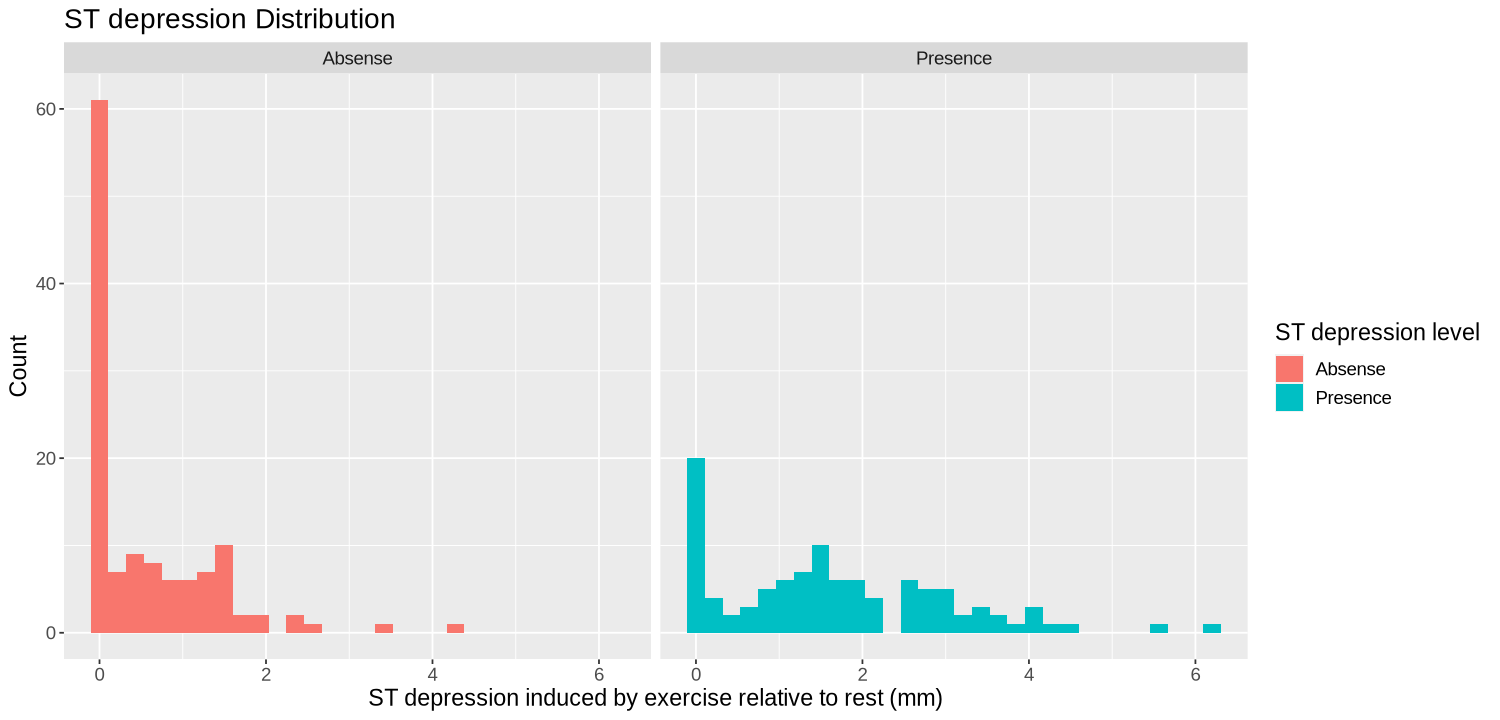

In [29]:
# Age
options(repr.plot.width=12, repr.plot.height=6)
age_distribution <- ggplot(heart_train, aes(x = Age, fill = as_factor(Status))) + 
                    geom_histogram() +
                    facet_grid(cols = vars(Status)) + 
                    labs(x = "Age (Years)", y = "Count", fill = "Age") +
                    ggtitle("Age Distribution") +
                    theme(text = element_text(size = 14))
age_distribution

# Resting Blood Pressure
options(repr.plot.width=13, repr.plot.height=6)
rbp_distribution <- ggplot(heart_train, aes(x = Resting_Blood_Pressure, fill = as_factor(Status))) + 
                    geom_histogram() +
                    facet_grid(cols = vars(Status)) + 
                    labs(x = "Resting Blood Pressure (mmHg)", y = "Count", fill = "Resting Blood Pressure") +
                    ggtitle("Resting Blood Pressure Distribution") +
                    theme(text = element_text(size = 14))
rbp_distribution

# Serum Cholestoral
options(repr.plot.width=12.5, repr.plot.height=6)
chol_distribution <- ggplot(heart_train, aes(x = Serum_Cholestoral, fill = as_factor(Status))) + 
                    geom_histogram() +
                    facet_grid(cols = vars(Status)) + 
                    labs(x = "Serum Cholestoral (mg/dL)", y = "Count", fill = "Serum Cholestoral") +
                    ggtitle("Serum Cholestoral Distribution") +
                    theme(text = element_text(size = 14))
chol_distribution

# Maximum Heart Rate
options(repr.plot.width=14, repr.plot.height=6)
maxhr_distribution <- ggplot(heart_train, aes(x = Max_Heart_Rate, fill = as_factor(Status))) + 
                    geom_histogram() +
                    facet_grid(cols = vars(Status)) + 
                    labs(x = "Maximum Heart Rate (bpm)", y = "Count", fill = "Maximum Heart Rate achieved	") +
                    ggtitle("Maximum Heart Rate Distribution") +
                    theme(text = element_text(size = 14))
maxhr_distribution

# ST depression
options(repr.plot.width=12.5, repr.plot.height=6)
st_distribution <- ggplot(heart_train, aes(x = ST_depression, fill = as_factor(Status))) + 
                    geom_histogram() +
                    facet_grid(cols = vars(Status)) + 
                    labs(x = "ST depression induced by exercise relative to rest (mm)", y = "Count", fill = "ST depression level") +
                    ggtitle("ST depression Distribution") +
                    theme(text = element_text(size = 14))
st_distribution

In all the plots above, we can observe that the dataset is well distributed for all the predictor variables which confirms that the predictors chosen are ideal for the classfication problem.

## Methods

In [ ]:
#Explain how you will conduct either your data analysis and which variables/columns you will use.
#Describe at least one way that you will visualize the results.

Because the dataset we loaded has already determined whether the patient has heart disease (listed in column "Status"), 
we will use the technique of regression to make a model and test its accuracy of determining heart disease by comparing it to the non-filtered graph (at the beginning).
The variables we have chosen to use in our model to determine the presence of heart disease are Age, Chest Pain Type, Resting Blood Pressure, and Serum Cholestoral.

To visualize the results we will...

# If you guys have any ideas for this I am all ears.

## Expected outcomes and significance:

## References

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

Centers for Disease Control and Prevention. (2021, July 19). Coronary artery disease. Centers for Disease Control and Prevention. https://www.cdc.gov/heartdisease/coronary_ad.htm 